<a href="https://colab.research.google.com/github/awikner/TREND/blob/master/TRENDreservoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the required neural network functions. Feel free to go to the github page and examine the functions there.

In [18]:
!git clone https://github.com/awikner/TREND.git

fatal: destination path 'TREND' already exists and is not an empty directory.


In [19]:
%run TREND/reservoir.py
%run TREND/lorenz.py

<Figure size 432x288 with 0 Axes>

## Import common libraries for plotting and linear algebra

In [20]:
import matplotlib.pyplot as plt
import scipy

## Run the Lorenz toy model that simulates a chaotic dynamical system and generate data

In [21]:
ModelParams = Model() 
ModelParams.a = 10
ModelParams.b = 28
ModelParams.c = 8.0/3.0;
ModelParams.tau = 0.01
ModelParams.nstep = 100000

np.random.seed(1)

init_cond  = np.random.normal(0, 1, (3,))
generateddata = rk_lorenz_solve(init_cond, ModelParams)[:,1000::5]

## Plot the X variable as a function of time

Text(0.5, 1.0, 'Lorenz Model Time Series')

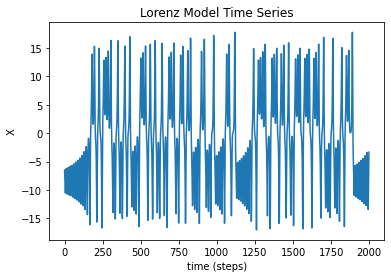

In [22]:
noise_scale = 0.01
generateddata = generateddata + np.random.normal(0, noise_scale, generateddata.shape)
data = np.zeros((3, generateddata.shape[1]))
data = generateddata
num_inputs = data.shape[0]

plt.plot(data[0, 0:1999])
plt.xlabel('time (steps)')
plt.ylabel('X')
plt.title('Lorenz Model Time Series')

## Plot the Y variable as a function of time

Text(0.5, 1.0, 'Lorenz Model Time Series')

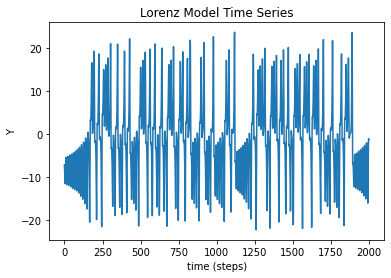

In [23]:
plt.plot(data[1, 0:1999])
plt.xlabel('time (steps)')
plt.ylabel('Y')
plt.title('Lorenz Model Time Series')

## Plot the Z variable as a function of time

Text(0.5, 1.0, 'Lorenz Model Time Series')

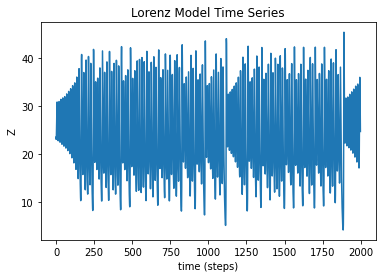

In [24]:
plt.plot(data[2, 0:1999])
plt.xlabel('time (steps)')
plt.ylabel('Z')
plt.title('Lorenz Model Time Series')

## Build the neural network

In [164]:
resparams = reservoir_parameters()
resparams.radius = 0.6
resparams.degree = 3
approx_res_size = 1000
resparams.N = int(np.floor(approx_res_size/num_inputs)*num_inputs)
resparams.sigma = 0.1
resparams.train_length = 5000
resparams.num_inputs = num_inputs;
resparams.predict_length = 5000
resparams.beta = 0.0001

In [165]:
A = generate_reservoir(resparams.N, resparams.radius, resparams.degree)

win = generate_input_layer(resparams)

## Run the neural network and generate the 'hidden space' states

In [166]:
states = np.zeros((resparams.N, resparams.train_length))

for i in range(resparams.train_length - 1):
  states[:,i+1] = np.tanh(A.dot(states[:,i]) + np.dot(win,data[:,i]))

r = states[:, resparams.train_length-1]


## Assign the hidden space states to the independent variable X and the target predictions as the dependent variable y

In [167]:
X = states
y = data[:, :resparams.train_length]
idenmat = np.eye(resparams.N)

## Analytically solve the linear regression problem 

In [168]:
w_out = np.dot(np.dot(y, X.T), scipy.linalg.pinv2(np.dot(X, X.T) + resparams.beta*idenmat)).reshape(3,-1)

## Predict the future using the neural network by stacking the single step predictions on top of each other

In [169]:
r = states[:, resparams.train_length-1]

predictions = np.zeros((3, resparams.predict_length))

for t in range(resparams.predict_length -1):
	out = np.dot(w_out, r)
	r = np.tanh(A.dot(r) + np.dot(win,out))
	predictions[:, t] = out

## Compare the prediction with the truth

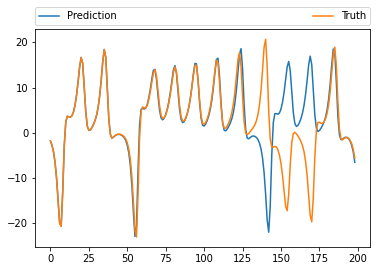

In [170]:
plt.plot(predictions.T[1:200,1], label= 'Prediction')
plt.plot(data[1, resparams.train_length:resparams.train_length+200-1],  label = 'Truth')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

## Look at the attractor made by the neural network

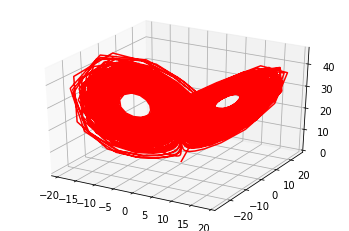

In [171]:
from mpl_toolkits import mplot3d

%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
xline = predictions.T[1:,0]
yline = predictions.T[1:,1]
zline = predictions.T[1:,2]
ax.plot3D(xline, yline, zline, 'r')



## Compare with the true attractor

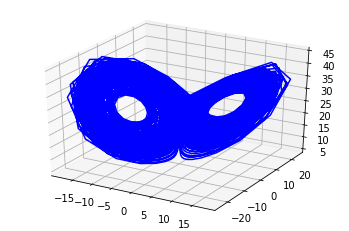

In [155]:
compare = data[:, resparams.train_length:resparams.train_length+resparams.predict_length-1]


fig = plt.figure()
ax = plt.axes(projection='3d')
xline = compare.T[1:,0]
yline = compare.T[1:,1]
zline = compare.T[1:,2]
ax.plot3D(xline, yline, zline, 'blue')